# COVID 19 - Compartmental Model Simulation

## Model

We define the following compartments:
- **$S$** is individuals who are at risks of Covid-19 infection
- **$I$** is infected individuals including asymptomatic and mild cases
- **$G$** is infected people who developed more severe cases of symptoms and required hospitalization
- **$P$** is those who recovered, and are seropositive and immune
- **$N$** is individuals who are recovered, immune but seronegative

We also introduce the attributes age ($a$), gender ($g$) and social activity group ($s$) differentiating individuals in a population.

Our model is formulated as a system of ordinary differential equations:

\begin{align*}
\tag{1}
& \dot{S}_{g,s,a} & = & -\lambda_{g,s,a}(t)S_{g,s,a} + (P_{g,s,a} + N_{g,s,a})/DI_g + \frac{1}{r}S_{g,s,a-1} - \frac{1}{r}S_{g,s,a} + &\\
&&& \frac{1}{R}\sum_{g,s}(S_{g,s,20} + I_{g,s,20} + G_{g,s,20} + P_{g,s,20} + N_{g,s,20}) \times &\\
&&& \delta_1(a)(\pi_1\delta_1(s) + \pi_2\delta_2(s) + \pi_3\delta_3(s) + \pi_4\delta_4(s)) &\\ \\
\tag{2}
& \dot{I}_{g,s,a}  & = &  \lambda_{g,s,a}(t)S_{g,s,a} - (1/WIP_g + 1/DAI_g)I_{g,s,a} + \frac{1}{r}I_{g,s,a-1}-\frac{1}{r}I_{g,s,a} &\\ \\
\tag{3}
& \dot{G}_{g,s,a}  & = &  I_{g,s,a}/WIP_g - G_{g,s,a}/DWT_g + \frac{1}{r}G_{g,s,a-1} - \frac{1}{r}G_{g,s,a} &\\ \\ 
\tag{4}
& \dot{P}_{g,s,a}  & = &  PSC_g(I_{g,s,a}/DAI_g + G_{g,s,a}/DWT_g) - P_{g,s,a}/DI_g + \frac{1}{r}P_{g,s,a-1} - \frac{1}{r}P_{g,s,a} &\\ \\
\tag{5}
& \dot{N}_{g,s,a}  & = &  (1-PSC_g)(I_{g,s,a}/DAI_g + G_{g,s,a}/DWT_g) - N_{g,s,a}/DI_g + \frac{1}{r}N_{g,s,a-1}-\frac{1}{r}N_{g,s,a} &\\ \\
\end{align*}

- $a$ : age - is 5-year band
- $g$ : gender - male = 0, female = 1
- $s$ : social intereaction category - active = 1, not active = 0

$
r = 5 * 365 = 1825 \\
R = 2 * 2 * 1825 = 7300
$

An important metric used to characterised the epidemic is $\mathcal{R}_0$ which is defined as:

$$
\mathcal{R}_0 = \tau \cdot \bar{c} \cdot d
$$

$\tau$ : the transmissibility (i.e., probability of infection given contact between a susceptible and infected individual)

$\bar{c}$ :  the average rate of contact between susceptible and infected individuals

$d$ : the duration of infectiousness

$\mathcal{R}_0$ is estimated to be between $2.76$ and $3.25$.

## Code

In [1]:
import pixiedust

Pixiedust database opened successfully


In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(123)

STATES = ['S', 'I', 'G', 'P', 'N']

ages = np.arange(0, 101, 25, np.int32)

A_CATEGORIES = [str(t) for t in zip(ages, ages[1:])]
G_CATEGORIES = ["male", "female"]
S_CATEGORIES = ["high", "low"]

In [3]:
def _np_divide_non_zero(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

def intensity(t, g, s, a, S, I, G, P, N, beta, c):
    opposite_group_ratio = _np_divide_non_zero(I, (S + I + G + P + N))
    infectious_interactions = np.sum(c[g,:, s,:, a,:] * opposite_group_ratio)
    return beta[g] * infectious_interactions

def dS(t, g, s, a, S=None, I=None, G=None, P=None, N=None, beta=None, c=None, di=None, sip=None, r=None, **kwargs):
    dSdt = - intensity(t, g, s, a, S, I, G, P, N, beta, c) * S[g, s, a] + \
        (P[g, s, a] + N[g, s, a]) / di[g] - S[g, s, a] / r + int(bool(a)) * S[g, s, a-1] / r
    
    if a != 0:
        return dSdt
        
    R = len(G_CATEGORIES) * len(S_CATEGORIES)
    inflow = np.sum(
        np.sum([
            S[:,:,-1], 
            I[:,:,-1],
            G[:,:,-1],
            P[:,:,-1],
            N[:,:,-1]
        ]) * sip / r
    )
            
    return dSdt + inflow / R

def dI(t, g, s, a, S=None, I=None, G=None, P=None, N=None, beta=None, c=None, wip=None, dai=None, r=None, **kwargs):
    dIdt = intensity(t, g, s, a, S, I, G, P, N, beta, c) * S[g, s, a] - \
        (1/wip[g] + 1/dai[g]) * I[g, s, a] - I[g, s, a] / r + int(bool(a)) * I[g, s, a-1] / r
    
    return dIdt

def dG(t, g, s, a, I=None, G=None, wip=None, dwt=None, r=None, **kwargs):
    dGdt = I[g, s, a] / wip[g] - G[g, s, a] / dwt[g] - G[g, s, a] / r + int(bool(a)) * G[g, s, a-1] / r
    
    return dGdt

def dP(t, g, s, a, I=None, G=None, P=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dPdt = psc[g] * (I[g, s, a] / dai[g] + G[g, s, a] / dwt[g]) - P[g, s, a] / di[g] - \
        P[g, s, a] / r + int(bool(a)) * P[g, s, a-1] / r
    
    return dPdt

def dN(t, g, s, a, I=None, G=None, N=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dNdt = (1-psc[g]) * (I[g, s, a] / dai[g] + G[g, s, a] / dwt[g]) - \
        N[g, s ,a]/di[g] - N[g, s, a] / r + int(bool(a)) * N[g, s, a-1] / r
    
    return dNdt

DELTAS_FUNC = {
    "S": dS, "I": dI, "G": dG, "P": dP, "N": dN
}

def system(y, t, params):
    """System of ODEs
    
    Params:
        y (array) : the current state
        t (float) : the current time
        sip (array) : the proportion of people in each social interaction group (sum(sip) = 1)
        beta (array) : the transmission probabilities
        c (array) : mean per capita at which an individual interact with a new individual from g', s', a'
        di (array) : duration of immunity
        wip (array) : incubation period
        dai (array) : duration of asymptomatic infection symptoms
        dwt (array) : duration of treatment
        psc (array) : probability of becoming seropositive
        r (int) : the number of days for someone to move to the upper age category
    """
    params = {k: v for k, v in zip(
        ["sip", "beta", "c", "di", "wip", "dai", "dwt", "psc", "r"], 
        deflatten_params(params))
    }
    
    states_ = y.reshape((len(STATES), len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
    states = {}
    for i, state in enumerate(STATES):
        states[state] = states_[i]
        
    deltas = {
        state: np.empty((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
        for state in STATES
    }

    lengths = [len(STATES), len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)]
    
    ret = [None]*np.prod(lengths)
    for i_state, state in enumerate(STATES):
        for i_g in range(len(G_CATEGORIES)):
            for i_s in range(len(S_CATEGORIES)):
                for i_a in range(len(A_CATEGORIES)):
                    idx = np.dot(
                        [i_state, i_g, i_s, i_a], 
                        [np.prod(lengths[i:] + [1]) for i in range(1, len(lengths)+1)]
                    )
                    ret[idx] = DELTAS_FUNC[state](t, i_g, i_s, i_a, **states, **params)
                    
    return ret

In [4]:
def generate_initial_state(n=100, infected_ratio=0.5, seed=123):
    """Generate a random initial state
    
    Params:
        n (int): the population size
        infected_ratio (float): the ratio of people infected in the population
        seed (int): the random seed to use
    """
    np.random.seed(seed)
    
    ages = np.random.randint(len(A_CATEGORIES), size=n)
    genders = np.random.randint(len(G_CATEGORIES), size=n)
    social_interactions = np.random.randint(len(S_CATEGORIES), size=n)
    
    initial_states = {
        state: np.zeros((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
        for state in STATES
    }
    
    for i, (a, g, s) in enumerate(zip(ages, genders, social_interactions)):
        if i < int(n*infected_ratio):
            initial_states["I"][g, s, a] += 1
        else:
            initial_states["S"][g, s, a] += 1
            
    for state in STATES:
        initial_states[state] = initial_states[state].flatten()
        
    return np.concatenate(tuple(initial_states[state] for state in STATES))

In [5]:
def generate_social_interaction_matrix(flatten=False):
    ret = np.ones((
        len(G_CATEGORIES), len(G_CATEGORIES), 
        len(S_CATEGORIES), len(S_CATEGORIES),
        len(A_CATEGORIES), len(A_CATEGORIES)
    ))
    
    if flatten:
        return ret.flatten()
    return ret

In [6]:
def flatten_params(*params):
    return np.hstack([p.flatten() if isinstance(p, (np.ndarray,)) else p for p in params])

def deflatten_params(params):
    shapes = np.array([
        (len(S_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES), len(G_CATEGORIES), len(S_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES), len(A_CATEGORIES)),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (2,),
        1
    ])
    
    length_parameters = [
        np.prod(s) if s != 1 else s
        for s in shapes
    ]
    
    split_indices = np.cumsum(length_parameters)
    
    return tuple(
        a.reshape(s) if s != 1 else a[0] 
        for s, a in zip(shapes, np.split(params, split_indices[:-1]))
    )

In [7]:
state0 = generate_initial_state()
t = np.linspace(0, 100, 101)

args = flatten_params(*(
    np.array([0.8, 0.2]),                  # sip
    np.array([0.4, 0.2]),                  # beta
    generate_social_interaction_matrix(),  # c
    np.array([2, 2]),                      # di
    np.array([7, 7]),                      # wip
    np.array([3, 3]),                      # dai
    np.array([14, 14]),                    # dwt
    np.array([0.5, 0.5]),                  # psc
    1825.,                                 # r
))

class CompartmentModel(object):
    
    def __init__(self, times, state0=None):
        self.times = times
        self.state0 = state0 if state0 is not None else generate_initial_state()
        
    def run(self, *args):
        return odeint(system, state0, t, args=(args,), rtol=1e-6, atol=1e-6)
    
    @staticmethod
    def _build_history(sol):
        """Reconstruct the history from the output of the ODE solver

        Params:
            sol (array): the output of the ODE solver

        Returns:
            hist (array): the array of shape (len(t), len(G), len(S), len(A))
        """
        hists = {
            state: [] for state in STATES
        }

        for t, states_t in enumerate(sol):
            for state, vals in zip(STATES, np.array_split(states_t, len(STATES))):
                hists[state].append(
                    vals.reshape((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
                )

        return {s : np.array(h) for s, h in hists.items()}
    
    def plot(self, sol, gender, social_interaction, age, obs=None):
        G = G_CATEGORIES.index(gender)
        S = S_CATEGORIES.index(social_interaction)
        A = A_CATEGORIES.index(age)

        plt.figure(figsize=(20,10))

        if obs is not None:
            obs_hists = self._build_history(obs)
            plt.plot(self.times[1:], obs_hists["S"][:, G, S, A], marker='o', color="C0", linestyle='none')
            plt.plot(self.times[1:], obs_hists["I"][:, G, S, A], marker='o', color="C1", linestyle='none')
            plt.plot(self.times[1:], obs_hists["G"][:, G, S, A], marker='o', color="C2", linestyle='none')
            plt.plot(self.times[1:], obs_hists["P"][:, G, S, A], marker='o', color="C3", linestyle='none')
            plt.plot(self.times[1:], obs_hists["N"][:, G, S, A], marker='o', color="C4", linestyle='none')

        hists = self._build_history(sol)
        plt.plot(self.times, hists["S"][:, G, S, A], color="C0", label=f'$S(t)$')
        plt.plot(self.times, hists["I"][:, G, S, A], color="C1", label=f'$I(t)$')
        plt.plot(self.times, hists["G"][:, G, S, A], color="C2", label=f'$G(t)$')
        plt.plot(self.times, hists["P"][:, G, S, A], color="C3", label=f'$P(t)$')
        plt.plot(self.times, hists["N"][:, G, S, A], color="C4", label=f'$N(t)$')

        plt.legend(loc='best')
        plt.xlabel('t')
        plt.grid()
        plt.show()

model = CompartmentModel(t, state0)
sol = model.run(*args)

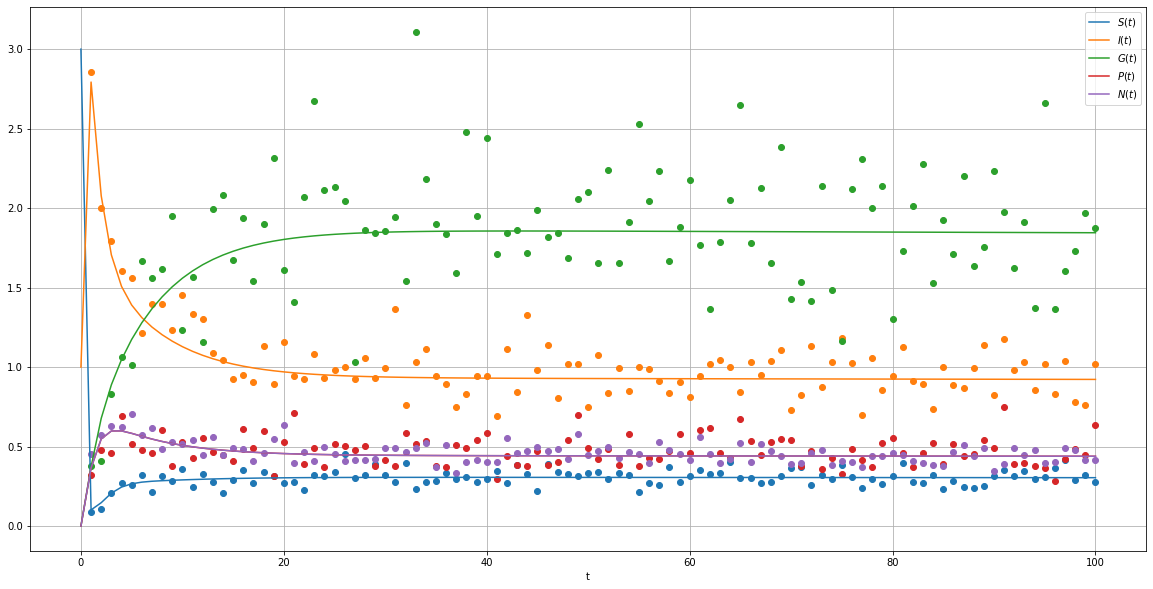

In [8]:
# Observational model
np.random.seed(123)

obs = np.random.lognormal(
    mean=np.log(sol[1::]), 
    sigma=np.random.uniform(0.1, 0.3, size=sol.shape[1])
)
    
model.plot(sol, "male", "high", "(25, 50)", obs=obs)

## Simulation

In [10]:
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano
import theano.tensor as tt

In [11]:
def _tt_divide_non_zero(a, b):
    return tt.switch(tt.eq(b, 0), 0, a / b)

def intensity_(t, g, s, a, S, I, G, P, N, beta, c):
    opposite_group_ratio = _tt_divide_non_zero(I, (S + I + G + P + N))
    infectious_interactions = tt.sum(c[g,:, s,:, a,:] * opposite_group_ratio)
    return beta[g] * infectious_interactions

def dS_(t, g, s, a, S=None, I=None, G=None, P=None, N=None, beta=None, c=None, di=None, sip=None, r=None, **kwargs):
    dSdt = - intensity_(t, g, s, a, S, I, G, P, N, beta, c) * S[g, s, a] + \
        (P[g, s, a] + N[g, s, a]) / di[g] - S[g, s, a] / r + int(bool(a)) * S[g, s, a-1] / r
    
    if a != 0:
        return dSdt
        
    R = len(G_CATEGORIES) * len(S_CATEGORIES)
    inflow = tt.sum(
        tt.sum([
            S[:,:,-1], 
            I[:,:,-1],
            G[:,:,-1],
            P[:,:,-1],
            N[:,:,-1]
        ]) * sip / r
    )
            
    return dSdt + inflow / R

def dI_(t, g, s, a, S=None, I=None, G=None, P=None, N=None, beta=None, c=None, wip=None, dai=None, r=None, **kwargs):
    dIdt = intensity_(t, g, s, a, S, I, G, P, N, beta, c) * S[g, s, a] - \
        (1/wip[g] + 1/dai[g]) * I[g, s, a] - I[g, s, a] / r + int(bool(a)) * I[g, s, a-1] / r
    
    return dIdt

def dG_(t, g, s, a, I=None, G=None, wip=None, dwt=None, r=None, **kwargs):
    dGdt = I[g, s, a] / wip[g] - G[g, s, a] / dwt[g] - G[g, s, a] / r + int(bool(a)) * G[g, s, a-1] / r
    
    return dGdt

def dP_(t, g, s, a, I=None, G=None, P=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dPdt = psc[g] * (I[g, s, a] / dai[g] + G[g, s, a] / dwt[g]) - P[g, s, a] / di[g] - \
        P[g, s, a] / r + int(bool(a)) * P[g, s, a-1] / r
    
    return dPdt

def dN_(t, g, s, a, I=None, G=None, N=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dNdt = (1-psc[g]) * (I[g, s, a] / dai[g] + G[g, s, a] / dwt[g]) - \
        N[g, s ,a]/di[g] - N[g, s, a] / r + int(bool(a)) * N[g, s, a-1] / r
    
    return dNdt

DELTAS_FUNC = {
    "S": dS_, "I": dI_, "G": dG_, "P": dP_, "N": dN_
}

def system_(y, t, params):
    """System of ODEs
    
    Params:
        y (array) : the current state
        t (float) : the current time
        sip (array) : the proportion of people in each social interaction group (sum(sip) = 1)
        beta (array) : the transmission probabilities
        c (array) : mean per capita at which an individual interact with a new individual from g', s', a'
        di (array) : duration of immunity
        wip (array) : incubation period
        dai (array) : duration of asymptomatic infection symptoms
        dwt (array) : duration of treatment
        psc (array) : probability of becoming seropositive
        r (int) : the number of days for someone to move to the upper age category
    """
    
    params = {k: v for k, v in zip(
        ["sip", "beta", "c", "di", "wip", "dai", "dwt", "psc", "r"], 
        deflatten_params(params))
    }
    
    states_ = y.reshape((len(STATES), len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
    states = {}
    for i, state in enumerate(STATES):
        states[state] = states_[i]
        
    deltas = {
        state: np.empty((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
        for state in STATES
    }

    lengths = [len(STATES), len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)]
    
    ret = [None]*np.prod(lengths)
    for i_state, state in enumerate(STATES):
        for i_g in range(len(G_CATEGORIES)):
            for i_s in range(len(S_CATEGORIES)):
                for i_a in range(len(A_CATEGORIES)):
                    idx = np.dot(
                        [i_state, i_g, i_s, i_a], 
                        [np.prod(lengths[i:] + [1]) for i in range(1, len(lengths)+1)]
                    )
                    ret[idx] = DELTAS_FUNC[state](t, i_g, i_s, i_a, **states, **params)
                    
    return ret

In [ ]:
with pm.Model() as sim_model:
    sigma = pm.HalfCauchy('sigma', 1, shape=state0.shape[0])

#     R0 = pm.Bound(pm.Normal, lower=1)('R0', 3., 0.25)
    
    # TODO : update the distributions
    sip = tt.as_tensor_variable([0.8, 0.2]) # pm.Dirichlet('sip', np.ones((len(S_CATEGORIES),)))
    beta = pm.Beta('beta', 3, 2, shape=len(G_CATEGORIES)) # tt.as_tensor_variable([0.4, 0.2])
    di = tt.as_tensor_variable([2., 2.]) # pm.Exponential('di', 1/2, shape=len(G_CATEGORIES))
    wip = tt.as_tensor_variable([7., 7.]) # pm.Exponential('wip', 1/7, shape=len(G_CATEGORIES))
    dai = tt.as_tensor_variable([3., 3.]) # pm.Exponential('dai', 1/3, shape=len(G_CATEGORIES))
    dwt = tt.as_tensor_variable([14., 14.]) # pm.Exponential('dwt', 1/14, shape=len(G_CATEGORIES))
    psc = tt.as_tensor_variable([0.5, 0.5]) # pm.Dirichlet('psc', np.ones((len(G_CATEGORIES),)))
    
    c = tt.as_tensor_variable(generate_social_interaction_matrix(False))  # c
    r = tt.as_tensor_variable(1825.)
    
    args_ = tt.concatenate([p.flatten() for p in [sip, beta, c, di, wip, dai, dwt, psc, r]])

    y_hat = pm.ode.DifferentialEquation(
        func=system_,
        times=t,
        n_states=len(state0), 
        n_theta=len(args)
    )(
        y0=state0,
        theta=args_,
        return_sens=True
    )
    
    # Change likelihood
    y_obs = pm.Normal("y_obs", mu=y_hat[1::], sd=sigma, observed=obs)
    
    trace = pm.sample(2000, tune=1000)
    

In [ ]:
pm.traceplot(trace)